#  <font color='red'> Bayesian Classification </font>

We obtain the probability distribution of the line parameters rather than scalar estimates of slope and y intercept.


In [1]:
import matplotlib.pyplot as plt
from matplotlib import cm
from mpl_toolkits.mplot3d import Axes3D


import numpy as np
import scipy as sc
from scipy.stats import multivariate_normal
import pandas as pd

plt.rcParams.update({'font.size': 16})
plt.rcParams['figure.figsize'] = [12, 6]


## Reading the data

In [2]:
fname = 'fishes.csv'
data = pd.read_csv(fname)
data.head(10)

,Fishtype,lightness,length
0,1.0,2.220252,-1.603168
1,1.0,3.771725,-3.621082
2,1.0,2.898739,-3.625635
3,1.0,4.484533,-1.227532
4,1.0,1.005928,-3.027846
5,0.0,-0.611962,0.252595
6,0.0,-1.617321,-0.085127
7,0.0,-1.086477,0.932646
8,1.0,2.255999,-2.207233
9,1.0,4.633921,-3.386524


## Extracting the different features

In [3]:
# Exctracting the fields with Fishtype=1 (bass)
bass = data[data["Fishtype"] == 1]
basslightness = bass['lightness'].to_numpy()
basslength = bass['length'].to_numpy()
basscount = bass['lightness'].count()

# Exctracting the fields with Fishtype=0 (salmon)
salmon = data[data["Fishtype"] == 0]
salmonlightness = salmon['lightness'].to_numpy()
salmonlength = salmon['length'].to_numpy()
salmoncount = salmon['lightness'].count()
bassfeatures = np.column_stack([basslightness,basslength])
salmonfeatures = np.column_stack([salmonlightness,salmonlength])

# Prior probabilities
pbass = basscount/(basscount+salmoncount)
psalmon = salmoncount/(basscount+salmoncount)

## Plotting the histogram

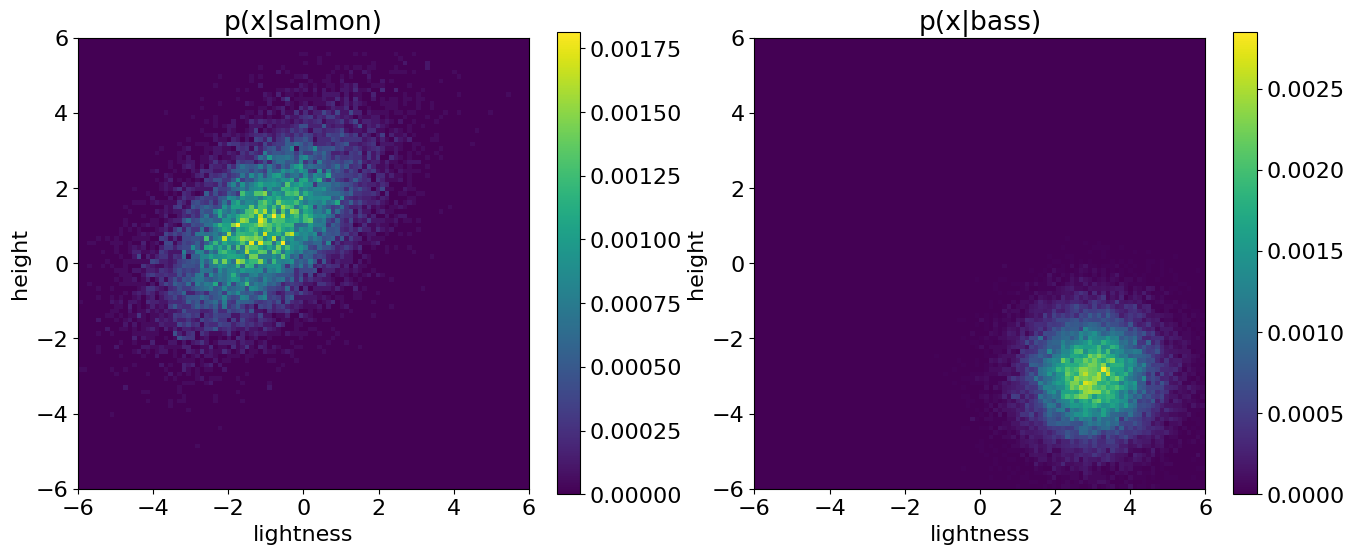

In [4]:
Nbins = 100
lbins = np.linspace(-6,6,Nbins+1)
hbins = np.linspace(-6,6,Nbins+1)

p_x_given_salmon, lbins, hbins = np.histogram2d(salmonfeatures[:,0],salmonfeatures[:,1], bins=(lbins, hbins))
p_x_given_salmon = p_x_given_salmon.T
p_x_given_salmon = p_x_given_salmon/salmoncount

fig = plt.figure(figsize=(16, 6))
ax = fig.add_subplot(121, title='p(x|salmon)')
s=plt.imshow(p_x_given_salmon, interpolation='nearest', origin='lower',
       extent=[lbins[0], lbins[-1], hbins[0], hbins[-1]])
s = plt.colorbar()
plt.xlabel('lightness')
plt.ylabel('height')

p_x_given_bass, lbins, hbins = np.histogram2d(bassfeatures[:,0],bassfeatures[:,1], bins=(lbins, hbins))
p_x_given_bass = p_x_given_bass.T
p_x_given_bass = p_x_given_bass/basscount


ax = fig.add_subplot(122, title='p(x|bass)')
s=plt.imshow(p_x_given_bass, interpolation='nearest', origin='lower',
       extent=[lbins[0], lbins[-1], hbins[0], hbins[-1]])
s = plt.colorbar()
s=plt.xlabel('lightness')
s=plt.ylabel('height')

## Estimating the Gaussian parameters.

The assumption is that the means of the distributions are the same, but their co-variance matrix is the same. Once the means of the features are estimated, they can be removed to get de-meaned features. The features can be pooled to obtain the covariance matrix. Compute the pdfs using the estimated parameters and compare to the actual ones.

Compute the discriminant by computing the difference between the log of the likelihood functions. You can threshold the discriminant to obtain the separating regions.

C:\Users\Brand\AppData\Local\Temp\ipykernel_24808\1520750786.py:10: DeprecationWarning: `row_stack` alias is deprecated. Use `np.vstack` directly.
  pooled_features = np.row_stack([salmon_demeaned,bass_demeaned])


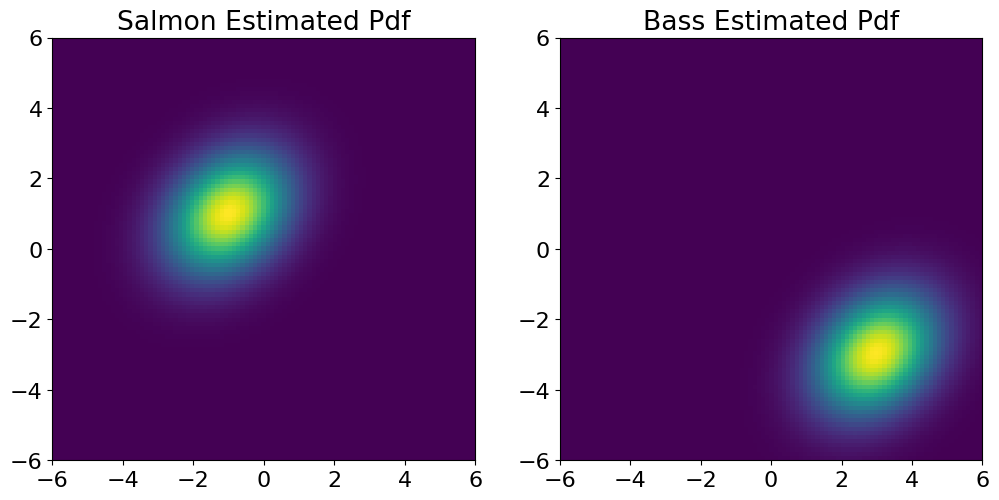

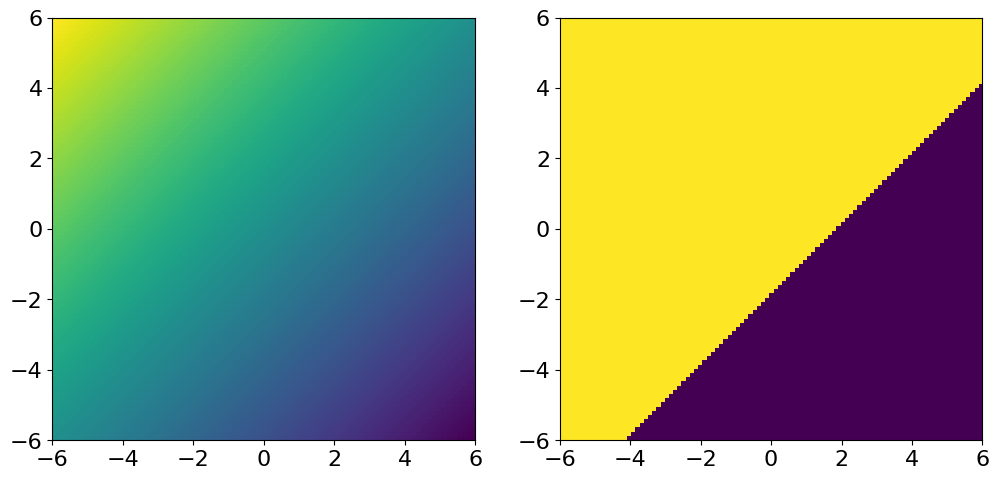

In [6]:

# Estimating the parameters
mean_salmon = np.mean(salmonfeatures,0)
mean_bass = np.mean(bassfeatures,0)

# Removing Menans
salmon_demeaned = salmonfeatures - mean_salmon[None,:]
bass_demeaned = bassfeatures - mean_bass[None,:]

# Estimating the covariance matrix
pooled_features = np.row_stack([salmon_demeaned,bass_demeaned])
shared_cov_mtx = np.cov(np.transpose(pooled_features))

x,y = np.meshgrid(hbins,lbins)
pos = np.empty(x.shape + (2,))
pos[:, :, 0] = x
pos[:, :, 1] = y

# Plotting the pdf
fig,axs  = plt.subplots(1,2)
F = multivariate_normal(mean_salmon, shared_cov_mtx)
Px_given_salmon = (F.pdf(pos))
s=axs[0].imshow(Px_given_salmon, interpolation='nearest', origin='lower',
       extent=[lbins[0], lbins[-1], hbins[0], hbins[-1]])
s=axs[0].set_title('Salmon Estimated Pdf')

F = multivariate_normal(mean_bass, shared_cov_mtx)
Px_given_bass= F.pdf(pos)
s=axs[1].imshow(Px_given_bass, interpolation='nearest', origin='lower',
       extent=[lbins[0], lbins[-1], hbins[0], hbins[-1]])
s=axs[1].set_title('Bass Estimated Pdf')


# TO DO #1: COMPUTE THE DISCRIMINANT
# Compute g1, g2, Discriminant, and SalmonRegion
#----------------------------------
g1 = np.log(psalmon) + multivariate_normal(mean=mean_salmon, cov=shared_cov_mtx).logpdf(pos)
g2 = np.log(pbass) + multivariate_normal(mean=mean_bass, cov=shared_cov_mtx).logpdf(pos)
Discriminant = g1 - g2
SalmonRegion = Discriminant > 0
#----------------------------------

fig,axs  = plt.subplots(1,2)
s=axs[0].imshow(Discriminant, interpolation='nearest', origin='lower',
       extent=[lbins[0], lbins[-1], hbins[0], hbins[-1]])

s=axs[1].imshow(SalmonRegion>0, interpolation='nearest', origin='lower',
       extent=[lbins[0], lbins[-1], hbins[0], hbins[-1]])



## To do: Impact of Priors

Add code below to compute the discriminants accounting for the priors of the two classes pbass and psalmon estimated above. Explain in the comments what you observe and explain why

Text(0.5, 1.0, 'Differences between two estimates')

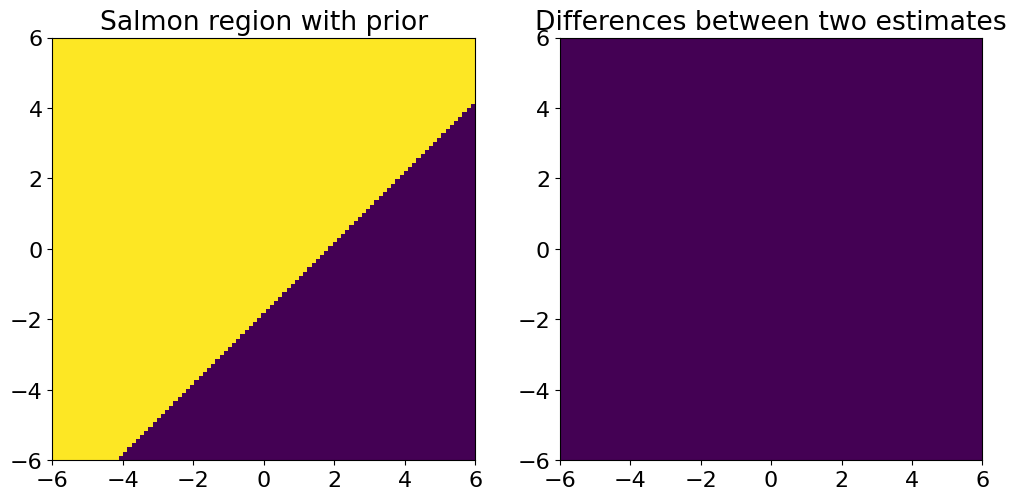

In [7]:
# TO DO #2: COMPUTE THE DISCRIMINANT
# Compute modified g1, g2, Discriminant, and SalmonRegion considering the priors of the classes
#----------------------------------
g1 = np.log(psalmon) + multivariate_normal(mean=mean_salmon, cov=shared_cov_mtx).logpdf(pos)
g2 = np.log(pbass) + multivariate_normal(mean=mean_bass, cov=shared_cov_mtx).logpdf(pos) 
Discriminant_with_prior = g1 - g2  # Difference between the discriminant functions with priors
SalmonRegion_with_prior = Discriminant_with_prior > 0  # Salmon region where g1_with_prior > g2_with_prior
# Discriminant = ??
# SalmonRegion = ??
#----------------------------------
Difference = np.bitwise_xor(SalmonRegion_with_prior,SalmonRegion)
fig,axs  = plt.subplots(1,2)
s=axs[0].imshow(Discriminant_with_prior>0, interpolation='nearest', origin='lower',
       extent=[lbins[0], lbins[-1], hbins[0], hbins[-1]])
axs[0].set_title('Salmon region with prior')

s=axs[1].imshow(Difference, interpolation='nearest', origin='lower',
       extent=[lbins[0], lbins[-1], hbins[0], hbins[-1]])
axs[1].set_title('Differences between two estimates')
